In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch


In [2]:
data = pd.read_csv('./bot.csv')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
data.drop(columns=['subcategory','pkSeqID','stime','flgs','category','state','proto','seq'],inplace=True)

In [4]:
data.rename(columns={"attack": "label"},inplace = True)

In [5]:
data.label.value_counts()

1    3668045
0        477
Name: label, dtype: int64

In [6]:
attack = data[data['label'] == 1].sample(frac=0.1)

In [7]:
normal = data[data['label'] == 0]

In [8]:
data = pd.concat([normal,attack])

In [9]:
data.label.value_counts()

1    366804
0       477
Name: label, dtype: int64

In [10]:
#le = LabelEncoder()
#le.fit_transform(data.label.values)
#data['label'] = le.transform(data['label'])

In [11]:
data['saddr'] = data.saddr.apply(str)
data['sport'] = data.sport.apply(str)
data['daddr'] = data.daddr.apply(str)
data['dport'] = data.dport.apply(str)

In [12]:
data['saddr'] = data.saddr.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [13]:
data['saddr'] = data['saddr'] + ':' + data['sport']
data['daddr'] = data['daddr'] + ':' + data['dport']

In [14]:
data.drop(columns=['sport','dport'],inplace=True)
label_ground_truth = data[["saddr", "daddr","label"]]
data = pd.get_dummies(data, columns = ['flgs_number','state_number', 'proto_number'])

In [15]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [16]:
data.fillna(0,inplace = True)

In [17]:
label_ground_truth = data[["saddr", "daddr","label"]]

In [18]:
data.drop(columns=['index'],inplace=True)

In [19]:
data

,saddr,daddr,pkts,bytes,ltime,dur,mean,stddev,sum,min,...,state_number_7,state_number_8,state_number_9,state_number_10,state_number_11,proto_number_1,proto_number_2,proto_number_3,proto_number_4,proto_number_5
0,172.21.112.246:-1,192.168.100.3:-1,4,240,1.526345e+09,1195.996582,0.000006,0.000002,0.000011,0.000004,...,0,0,0,0,0,0,1,0,0,0
1,172.20.226.196:139,192.168.100.4:36390,10,680,1.526346e+09,1453.945923,0.000028,0.000008,0.000138,0.000022,...,0,0,0,0,0,1,0,0,0,0
2,172.17.93.215:51838,27.124.125.250:123,2,180,1.526344e+09,0.048565,0.048565,0.000000,0.048565,0.048565,...,0,0,0,0,0,0,0,1,0,0
3,172.27.190.73:-1,192.168.100.7:-1,10,510,1.526346e+09,1454.080322,0.000238,0.000022,0.001189,0.000199,...,0,0,0,0,0,0,1,0,0,0
4,172.27.129.203:58999,192.168.100.1:53,4,630,1.526345e+09,569.933960,0.098505,0.080150,0.197011,0.018356,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367276,172.28.48.178:49132,192.168.100.6:80,7,890,1.528081e+09,24.177849,0.008363,0.010483,0.041813,0.000000,...,0,0,0,0,0,1,0,0,0,0
367277,172.17.196.135:26823,192.168.100.3:80,3,274,1.528081e+09,0.175381,0.175381,0.000000,0.175381,0.175381,...,0,0,0,0,0,1,0,0,0,0
367278,172.22.162.170:38759,192.168.100.3:49160,1,60,1.526345e+09,0.000069,0.000069,0.000000,0.000069,0.000069,...,0,0,0,0,0,0,0,1,0,0
367279,172.17.58.164:5345,192.168.100.3:80,16,960,1.528085e+09,32.101551,3.061918,1.754231,18.371506,0.000000,...,0,0,0,0,0,0,0,1,0,0


In [20]:
scaler = StandardScaler()
cols_to_norm = list(set(list(data.iloc[:, 2:].columns ))  - set(list(['label'])) )
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label_ground_truth, test_size=0.3, random_state=42, stratify=label_ground_truth.label)

In [22]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

<ipython-input-22-841b8327893c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['h'] = X_train[ cols_to_norm ].values.tolist()


In [23]:
#from dgl.data.utils import load_graphs   
#G = load_graphs("./data.bin")[0][0]

In [24]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h','label'], create_using= nx.MultiGraph())

In [25]:
G = G.to_directed()

In [26]:
G = from_networkx(G,edge_attrs=['h','label'])

In [27]:
#from dgl.data.utils import save_graphs
#save_graphs("./data.bin", [G])


In [28]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1]) 

In [29]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype= th.bool)

In [30]:
#G = load_graphs("./bot_train_G.bin") [0][0]

In [31]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [32]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [33]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [34]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        global score
        global emb
        emb = th.cat([h_u, h_v], 1)
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [35]:
G.ndata['h'].shape

torch.Size([261121, 1, 53])

In [36]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [37]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [38]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 2)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [39]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(G.edata['label'].cpu().numpy()),
                                                 G.edata['label'].cpu().numpy())

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[1 1 1 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [40]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [41]:
G = G.to('cuda:0')

In [42]:
G.device

device(type='cuda', index=0)

In [43]:
G.ndata['h'].device  

device(type='cuda', index=0)

In [44]:
G.edata['h'].device  

device(type='cuda', index=0)

In [45]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()

opt = th.optim.Adam(model.parameters())

for epoch in range(1,700):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Epoch: 100  Training acc: 0.9999358654022217
Epoch: 200  Training acc: 0.9999417066574097
Epoch: 300  Training acc: 0.9999533295631409
Epoch: 400  Training acc: 0.9999552965164185
Epoch: 500  Training acc: 0.9999552965164185
Epoch: 600  Training acc: 0.9999611377716064


In [46]:
#model.load_state_dict(th.load('bot_binary.pt'))
#model.eval()

In [47]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

<ipython-input-47-84be06ca8888>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['h'] = X_test[ cols_to_norm ].values.tolist()


In [48]:
#G_test = load_graphs("bot_test_G.bin") [0][0]
G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), 53)

In [49]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [50]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [51]:
G_test = G_test.to('cuda:0')

In [52]:
th.cuda.empty_cache()

In [53]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [54]:
print(str(elapsed) + ' seconds')

0.0490271840008063 seconds


In [55]:
test_pred = test_pred.argmax(1)

In [56]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [57]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [58]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

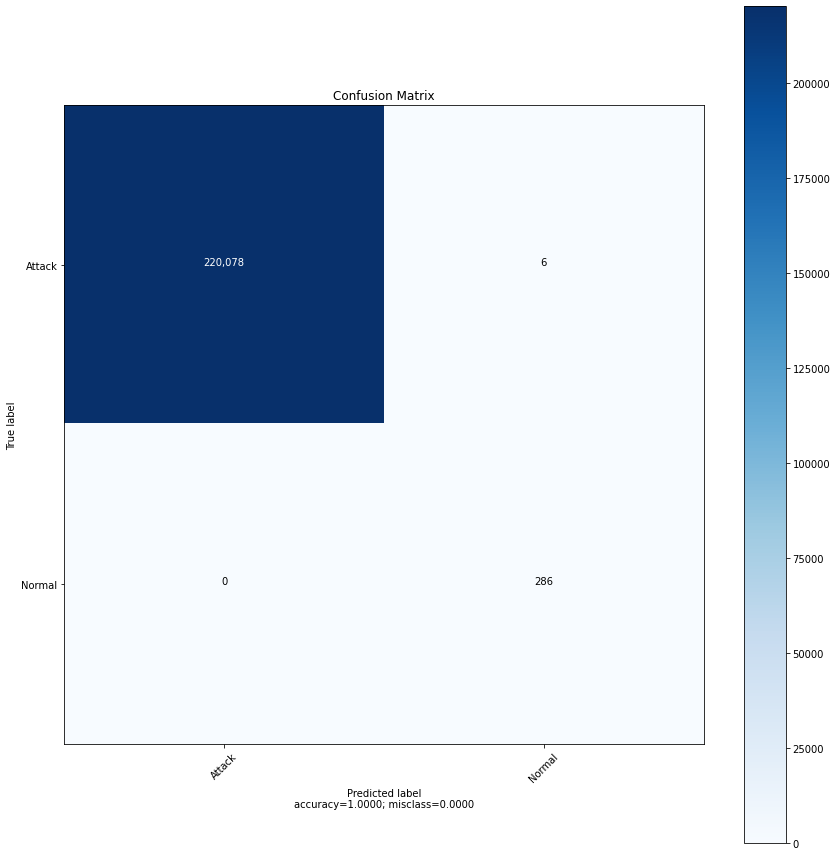

In [59]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")

In [60]:
from sklearn.metrics import classification_report
target_names = np.unique(actual)
print(classification_report(actual, test_pred, target_names=target_names, digits=4))

              precision    recall  f1-score   support

      Attack     1.0000    1.0000    1.0000    220084
      Normal     0.9795    1.0000    0.9896       286

    accuracy                         1.0000    220370
   macro avg     0.9897    1.0000    0.9948    220370
weighted avg     1.0000    1.0000    1.0000    220370



In [61]:
emb

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.3383, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0', grad_fn=<CatBackward>)

In [91]:
emb_num = emb.cpu().detach().numpy()


In [92]:
np.save('emb_bin.npy',emb_num)

In [93]:
emb_viz = np.load('emb_viz.npy')

In [94]:
emb_viz

array([[ 3.7198455, -1.7287366],
       [-6.592858 ,  4.200667 ],
       [-7.3762507,  4.031517 ],
       ...,
       [-0.6662593, 13.014032 ],
       [-1.2662965,  5.859787 ],
       [ 4.7889442, -3.0779557]], dtype=float32)

In [95]:
df_umap = pd.DataFrame(emb_viz, columns=['comp1', 'comp2'])


In [96]:
df_umap['label'] = actual


In [97]:
df_umap

,comp1,comp2,label
0,3.719846,-1.728737,Attack
1,-6.592858,4.200667,Attack
2,-7.376251,4.031517,Attack
3,-3.057451,-4.969083,Attack
4,-2.668613,-3.500797,Attack
...,...,...,...
220365,-2.679775,-12.759145,Attack
220366,2.871510,7.411801,Attack
220367,-0.666259,13.014032,Attack
220368,-1.266297,5.859787,Attack


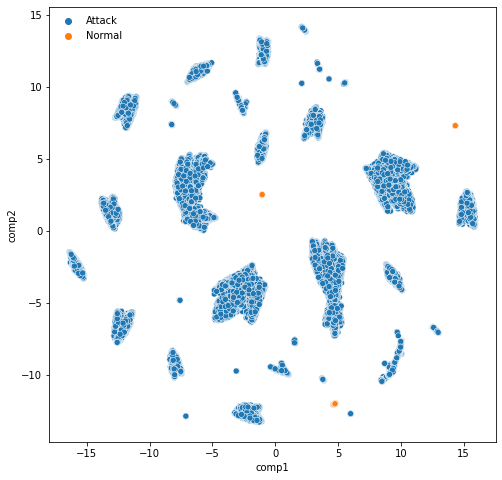

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8));
sns.scatterplot(x='comp1', y='comp2', data=df_umap, hue='label');
plt.legend(loc='upper left', frameon=False)

In [90]:
np.save('raw.npy',X_test.drop(columns=['saddr','daddr','h']).to_numpy())

In [100]:
raw_viz = np.load('raw_viz.npy')

In [101]:
raw_viz

array([[-2.1767569, -3.6114023],
       [ 5.960733 , -3.7344134],
       [ 9.069847 , -0.5271328],
       ...,
       [-5.4625006,  3.9939451],
       [ 6.8652   ,  8.14912  ],
       [-7.2472787, 10.231837 ]], dtype=float32)

In [102]:
df_umap = pd.DataFrame(raw_viz, columns=['comp1', 'comp2'])

In [103]:
y_label =  ["Normal" if i == 0 else "Attack" for i in y_test.label]

In [106]:
df_umap['label'] = y_label

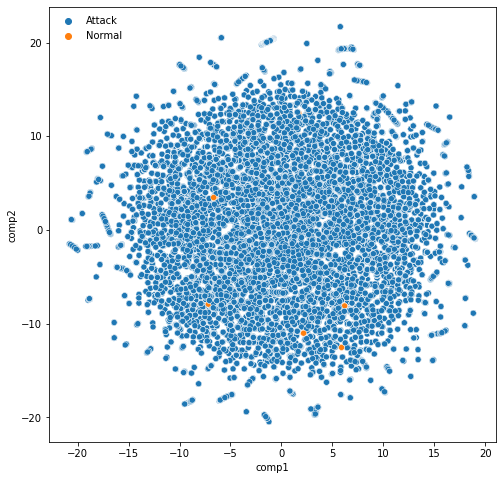

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8));
sns.scatterplot(x='comp1', y='comp2', data=df_umap, hue='label');
plt.legend(loc='upper left', frameon=False)